# GerryChain demo with Iowa data


## 1. Gathering the data and installing libraries

First, let's install GerryChain. The best way to install GerryChain on your local machine is to use conda, but we'll use pip here. Check out https://gerrychain.readthedocs.io/en/latest/user/install.html for installation guide.

In [ ]:
!pip install -q git+https://github.com/mggg/gerrychain

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q geopandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 62.3 MB/s eta 0:00:00


We will need some clean data. We will use the Iowa county shapefile available on mggg-states. 

In [ ]:
#clone the IA shapefiles repo from github
!git clone https://github.com/mggg-states/IA-shapefiles.git

Cloning into 'IA-shapefiles'...
remote: Enumerating objects: 12, done.
remote: Total 12 (delta 0), reused 0 (delta 0), pack-reused 12
Unpacking objects: 100% (12/12), 1.14 MiB | 1.88 MiB/s, done.


In [ ]:
#unzip the counties shapefile
!unzip IA-shapefiles/IA_counties.zip

Archive:  IA-shapefiles/IA_counties.zip
  inflating: IA_counties.dbf         
  inflating: IA_counties.shx         
  inflating: IA_counties.shp         
   creating: __MACOSX/
  inflating: __MACOSX/._IA_counties.shp  
  inflating: IA_counties.cpg         
  inflating: IA_counties.prj         


Let's import everything we will need from GerryChain, plus a few extra things.

In [ ]:
from gerrychain import Graph, Election, updaters, Partition, constraints, MarkovChain
from gerrychain.updaters import cut_edges
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept
from gerrychain.constraints import single_flip_contiguous
from gerrychain.random import random
import pandas as pd
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import geopandas as gpd

Let's look at our shapefile. 

<Axes: >

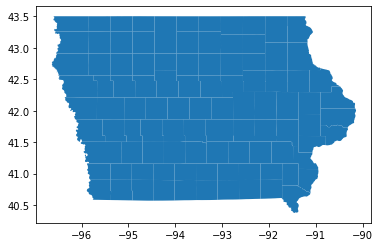

In [ ]:
gdf = gpd.read_file("IA_counties.shp")
gdf.plot()

In [ ]:
gdf.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,19064,10257,8472,335,17980,7652,9146,1182,1,"POLYGON ((-92.76679 42.12346, -92.76679 42.122..."
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,14023,6862,6940,221,13844,4678,8232,934,1,"POLYGON ((-91.94773 41.86186, -91.95514 41.861..."
2,19,041,19041,Clay,Clay County,1469139214,13866941,+43.0798220,-095.1497261,16667,...,8502,3385,4951,166,8617,2249,5877,491,4,"POLYGON ((-95.26926 43.25537, -95.26140 43.255..."
3,19,165,19165,Shelby,Shelby County,1530110414,1486135,+41.6790143,-095.3089173,12167,...,6483,2469,3911,103,6370,1662,4362,346,4,"POLYGON ((-95.20902 41.86371, -95.20890 41.863..."
4,19,043,19043,Clayton,Clayton County,2016405612,36586071,+42.8409979,-091.3235108,18129,...,9138,4806,4164,168,9129,3237,5317,575,1,"POLYGON ((-91.25080 42.64558, -91.25160 42.645..."


## 2. Setting up the initial plan and updaters for the chain

We have to convert the shapefile into a GerryChain Graph object. This can take a _really_ long time for big states. For Iowa it might take a few seconds. For that reason, it's a good idea to save your graph straight away so you can load it next time from a .json file.

In [ ]:
graph = Graph.from_file("IA_counties.shp")
graph.to_json("IA_counties.json")

/usr/local/lib/python3.9/dist-packages/gerrychain/graph/graph.py:179: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  areas = df.geometry.area.to_dict()


As GerryChain generates districting plans, we can read off properties of the plans (such as district vote shares or populations) using _updaters_. Since every shapefile is different, we need to create updaters for population, cut edges (discretized boundary length) and elections. Here are Iowa's:

In [ ]:
#call the elections whatever you like
election_names = ["PRES00","PRES04","PRES08","PRES12"] 
#these have to be shapefile column names, in (Democrat, Republican) pairs
election_columns = [["PRES00D", "PRES00R"],["PRES04D", "PRES04R"],["PRES08D", "PRES08R"],["PRES12D","PRES12R"]]
#the population column on the shapefile
pop_col = "TOTPOP"

In [ ]:
#basic updaters
myupdaters = {
    "population": updaters.Tally(pop_col, alias="population"),
    "cut_edges": cut_edges,
}
#election updaters using GerryChain Election objects
elections = [
    Election(name,{"Democratic": dem, "Republican": rep})
    for name, (dem, rep) in zip(election_names, election_columns)
]
election_updaters = {election.name: election for election in elections}
myupdaters.update(election_updaters)

We need an initial plan as a staring point (or "seed") for the chain. Here's how to make one from scratch. This can take a while too, so you can also use an enacted plan as a seed if you have one on the shapefile. **You can change the number of districts (4) and the maximum population deviation if you like.**

In [ ]:
total_population = sum([graph.nodes[n][pop_col] for n in graph.nodes])
assignment = recursive_tree_part(
    graph, 
    range(4), #district names, in this case {0,1,2,3}
    total_population/4, #ideal population for a district
    pop_col, 
    0.05 #maximum allowed population deviation, 5% for now
)
#make a GerryChain Partition object
initial_partition = Partition(graph, assignment, myupdaters)

Let's look at our seed plan. Here's an easy way to see a Partition object as a plan.

<Axes: >

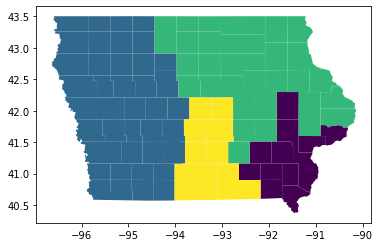

In [ ]:
initial_partition.plot(gdf) # you have to hand it gdf, the geodataframe for the graph

## 3. Running a flip walk chain

We need some constraints on what kind of plans our chain can generate. For flip walks, we are worried about contiguity and population balance. **Go ahead and tinker with the number of steps and the population deviation if you like.**

In [ ]:
myconstraints = [
    single_flip_contiguous, #fast contiguity tracker only for flip walks
    constraints.within_percent_of_ideal_population(initial_partition, 0.05) #population deviation
]
chain = MarkovChain(
    proposal=propose_random_flip,
    constraints=myconstraints,
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=1000 #number of steps
)

It's time to run a chain. A GerryChain MarkovChain object is iterable -- in other words, you run it like you're iterating through a list.

It's no good running the chain without storing something about the plans to look at, so let's store the Democratic vote shares for each plan, sorted in ascending order. We'll store the data in a list to start with, and then put it in a pandas DataFrame, which is easy to store as a csv later on. We'll also store the cut edges in a separate list. **You can also store any other data you like, for example step[e].seats('Democratic') gives you the number of Democratic-won districts.**

It's also good practice, when space is available, to store your partitions on the shapefile so you can look at them later. Let's store our plans as step1, step2 etc.

In [ ]:
votesharelists = {e: [] for e in election_names}
cutedges = []
flip_assignments = []
for i, step in enumerate(chain):
  print(i, end=" ")
  cutedges.append(len(step['cut_edges'])) #store cut edges
  flip_assignments.append([step.assignment[n] for n in graph.nodes])
  for e in election_names:
    votesharelists[e].append(sorted(step[e].percents("Democratic")))

flip_assignments_df = pd.DataFrame({
    f"flipstep{idx}": assignment
    for idx, assignment in enumerate(flip_assignments)
})
gdf = pd.concat([gdf, flip_assignments_df], axis=1)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

Now let's see what the dataframe looks like.  This is a pretty inefficient format, with one row per county and each step recorded in its own column; it wouldn't scale well.  But it's transparent for our purposes.

In [ ]:
gdf

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,flipstep990,flipstep991,flipstep992,flipstep993,flipstep994,flipstep995,flipstep996,flipstep997,flipstep998,flipstep999
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,2,2,2,2,2,2,2,2,2,2
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,2,2,2,0,0,0,0,0,0,0
2,19,041,19041,Clay,Clay County,1469139214,13866941,+43.0798220,-095.1497261,16667,...,1,1,1,1,1,1,1,1,1,1
3,19,165,19165,Shelby,Shelby County,1530110414,1486135,+41.6790143,-095.3089173,12167,...,1,1,1,1,1,1,1,1,1,1
4,19,043,19043,Clayton,Clayton County,2016405612,36586071,+42.8409979,-091.3235108,18129,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,19,111,19111,Lee,Lee County,1340366450,55293745,+40.6475875,-091.4771574,35862,...,0,0,0,0,0,0,0,0,0,0
95,19,169,19169,Story,Story County,1483592867,2152172,+42.0375379,-093.4660934,89542,...,3,3,3,3,3,3,3,3,3,3
96,19,075,19075,Grundy,Grundy County,1299805924,94406,+42.4033232,-092.7902613,12453,...,2,2,2,2,2,2,2,2,2,2
97,19,155,19155,Pottawattamie,Pottawattamie County,2147483647,22925740,+41.3401835,-095.5449053,93158,...,1,1,1,1,1,1,1,1,1,1


Let's look at sequences of four plans from the chain. **Go ahead and change the number to see different plans in the chain. Can you see what changes from one plan to the next?**


<Axes: >

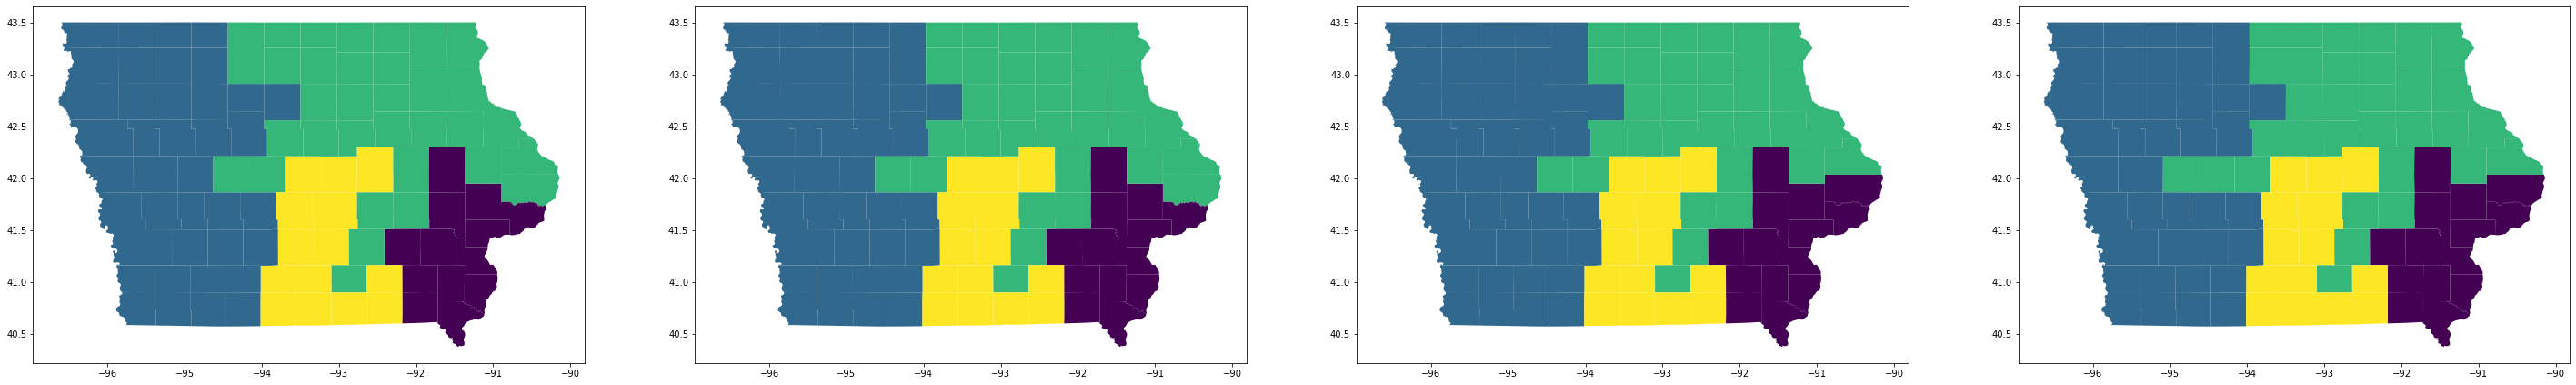

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(50, 100))
gdf.plot(column="flipstep{}".format(9),ax=axes[0])
gdf.plot(column="flipstep{}".format(10),ax=axes[1])
gdf.plot(column="flipstep{}".format(11),ax=axes[2])
gdf.plot(column="flipstep{}".format(12),ax=axes[3])

<Axes: >

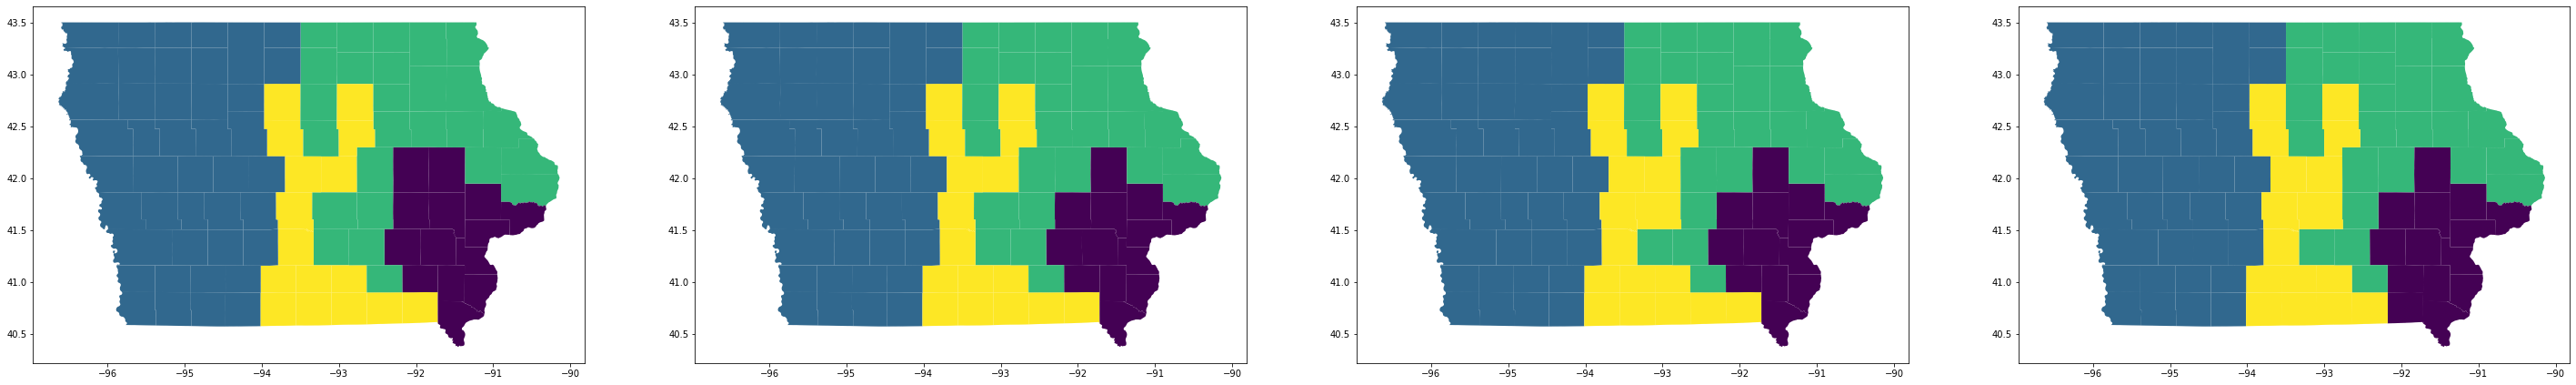

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(50, 100))
gdf.plot(column="flipstep{}".format(109),ax=axes[0])
gdf.plot(column="flipstep{}".format(110),ax=axes[1])
gdf.plot(column="flipstep{}".format(111),ax=axes[2])
gdf.plot(column="flipstep{}".format(112),ax=axes[3])

<Axes: >

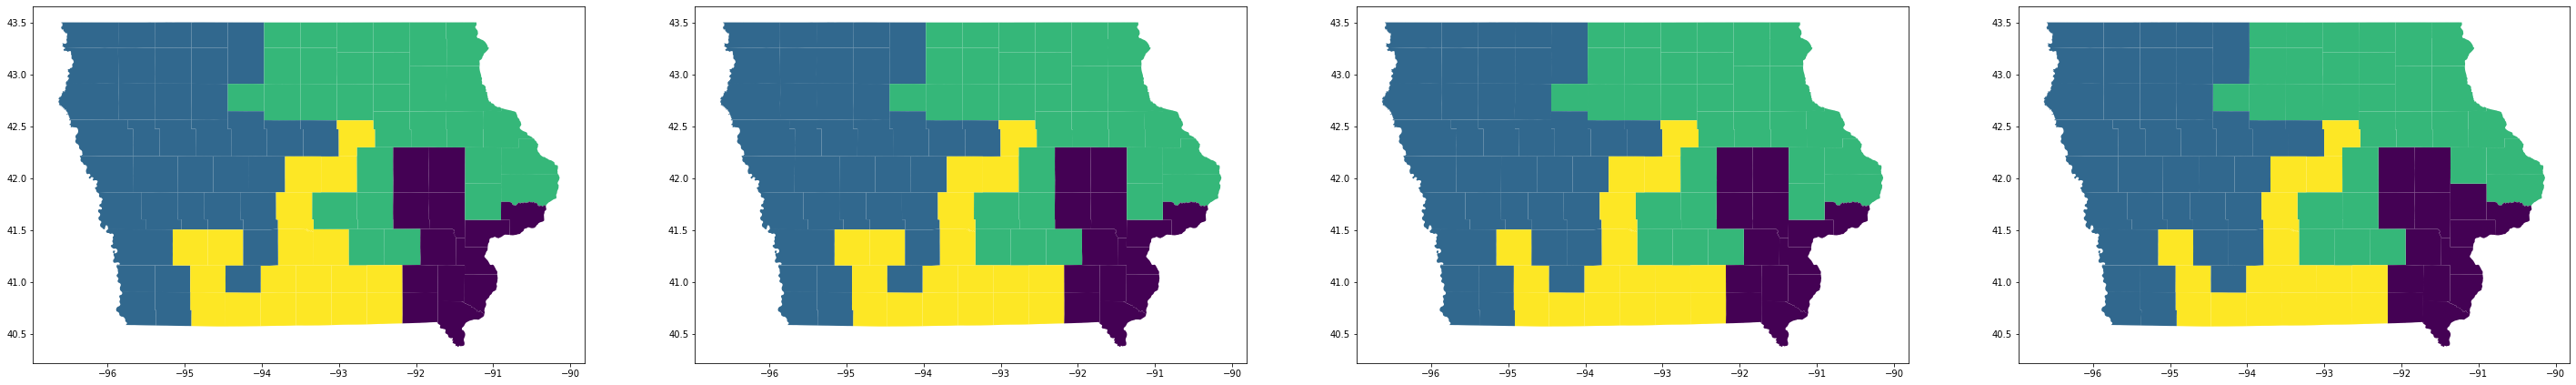

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(50, 100))
gdf.plot(column="flipstep{}".format(809),ax=axes[0])
gdf.plot(column="flipstep{}".format(810),ax=axes[1])
gdf.plot(column="flipstep{}".format(811),ax=axes[2])
gdf.plot(column="flipstep{}".format(812),ax=axes[3])

Let's look at our data. We'll pick one election and look at a table, then a box plot, of the vote shares. **We'll use PRES12 but you can use any election you like.**

In [ ]:
flipvoteshares = pd.DataFrame(votesharelists['PRES12']) #put it in a pandas DataFrame
flipvoteshares.head(10)

,0,1,2,3
0,0.430469,0.543038,0.549257,0.590176
1,0.430469,0.543510,0.549257,0.588605
2,0.430929,0.544855,0.549257,0.588605
3,0.426945,0.544477,0.549257,0.588605
4,0.426945,0.544477,0.549702,0.589716
5,0.426945,0.544627,0.549440,0.589716
6,0.425985,0.544091,0.549440,0.589716
7,0.426516,0.542152,0.549440,0.589716
8,0.426516,0.541406,0.550273,0.589716
9,0.425985,0.543317,0.550273,0.589716


For the boxplot, we're going to plot Obama's vote share against Romney in each district. District 0 is the least Democratic district, District 1 the second-least Democratic and so on. The y axis range is set automatically but you can un-comment the line specifying it from 0 to 1. Whiskers are set to 1st and 99th percentile.

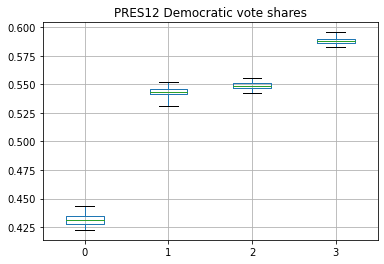

In [ ]:
flipvoteshares.boxplot(whis=(1,99),showfliers=False)
#plt.ylim(0,1)
plt.title('PRES12 Democratic vote shares')
plt.show()

Our favorite score of the shape of districts is called "cut edges": it's just the size of the cut-set in the dual graph, or in other words it counts the number of neighboring pairs of counties that have *different* district assignments.  Fewer cut edges means the plan is more "compact."

Let's look at the cut edges histogram as well.  Note that if this were a 10x10 grid being cut into four districts of 25 units each, the minimum possible cut edge score would be 20 (quadrants) and the maximum would be 84 (if each district were a tree).


(20.0, 84.0)

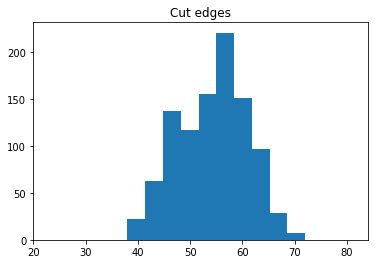

In [ ]:
plt.hist(cutedges)
plt.title("Cut edges")
plt.xlim(20,84)

## 4. Running a ReCom chain

Let's make an initial plan again.

In [ ]:
total_population = sum([graph.nodes[n][pop_col] for n in graph.nodes])
assignment = recursive_tree_part(
    graph, 
    range(4), #district names, in this case {0,1,2,3}
    total_population/4, #ideal population for a district
    pop_col, 
    0.05 #maximum allowed population deviation, 5% for now
)
#make a GerryChain Partition object
initial_partition = Partition(graph, assignment, myupdaters)

Running a ReCom chain is a simple matter of changing the proposal function, and adjusting the constraints.

In [ ]:
#no need for contiguity since that is forced by the proposal
myconstraints = [
    constraints.within_percent_of_ideal_population(initial_partition, 0.05)
] 
#little python trick to fix some parameters in the proposal function
myproposal = partial(
    recom,
    pop_col=pop_col,
    pop_target=total_population/4,
    epsilon=0.05, #population tolerance
    node_repeats=2 #parameter for spanning tree method, set to 2 is fine
)
chain = MarkovChain(
    proposal=myproposal,
    constraints=myconstraints,
    accept=always_accept,
    initial_state=initial_partition,
    total_steps=1000 #just a few steps to start with
)

We'll store the chain's data in the same way.

In [ ]:
recomcutedges = []
recom_assignments = []
votesharelists = {e: [] for e in election_names}
for i, step in enumerate(chain):
  print(step.flips)
  print(i, end=" ")
  recom_assignments.append([step.assignment[n] for n in graph.nodes])
  recomcutedges.append(len(step['cut_edges']))
  for e in election_names:
    votesharelists[e].append(sorted(step[e].percents("Democratic")))

recom_assignments_df = pd.DataFrame({
    f"recomstep{idx}": assignment
    for idx, assignment in enumerate(recom_assignments)
})
gdf = pd.concat([gdf, recom_assignments_df], axis=1)

None
0 {36: 0, 68: 0, 6: 0, 73: 0, 41: 0, 47: 0, 79: 0, 48: 0, 52: 0, 95: 0, 63: 0, 8: 3, 10: 3, 11: 3, 16: 3, 22: 3, 23: 3, 24: 3, 25: 3, 28: 3, 31: 3, 34: 3, 35: 3, 38: 3, 51: 3, 54: 3, 59: 3, 71: 3, 76: 3, 85: 3, 86: 3, 92: 3, 93: 3, 94: 3}
1 {7: 2, 30: 2, 36: 2, 41: 2, 43: 2, 44: 2, 46: 2, 47: 2, 48: 2, 55: 2, 58: 2, 65: 2, 66: 2, 67: 2, 68: 2, 73: 2, 77: 2, 79: 2, 97: 2, 2: 0, 3: 0, 6: 0, 9: 0, 12: 0, 13: 0, 14: 0, 15: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 26: 0, 29: 0, 32: 0, 39: 0, 40: 0, 42: 0, 49: 0, 50: 0, 52: 0, 56: 0, 57: 0, 60: 0, 61: 0, 63: 0, 64: 0, 69: 0, 70: 0, 72: 0, 80: 0, 84: 0, 87: 0, 90: 0, 91: 0, 95: 0, 98: 0}
2 {36: 2, 68: 2, 6: 2, 41: 2, 73: 2, 79: 2, 48: 2, 47: 2, 52: 2, 91: 2, 63: 2, 95: 2, 2: 0, 3: 0, 7: 0, 9: 0, 12: 0, 13: 0, 14: 0, 15: 0, 17: 0, 18: 0, 19: 0, 20: 0, 21: 0, 26: 0, 29: 0, 30: 0, 32: 0, 39: 0, 40: 0, 42: 0, 43: 0, 44: 0, 46: 0, 49: 0, 50: 0, 55: 0, 56: 0, 57: 0, 58: 0, 60: 0, 61: 0, 64: 0, 65: 0, 66: 0, 67: 0, 69: 0, 70: 0, 72: 0, 77: 0, 80: 

Like before, let's compare the initial partition to some sequences deeper in the chain.

<Axes: >

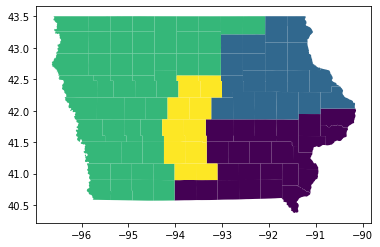

In [ ]:
initial_partition.plot(gdf)

<Axes: >

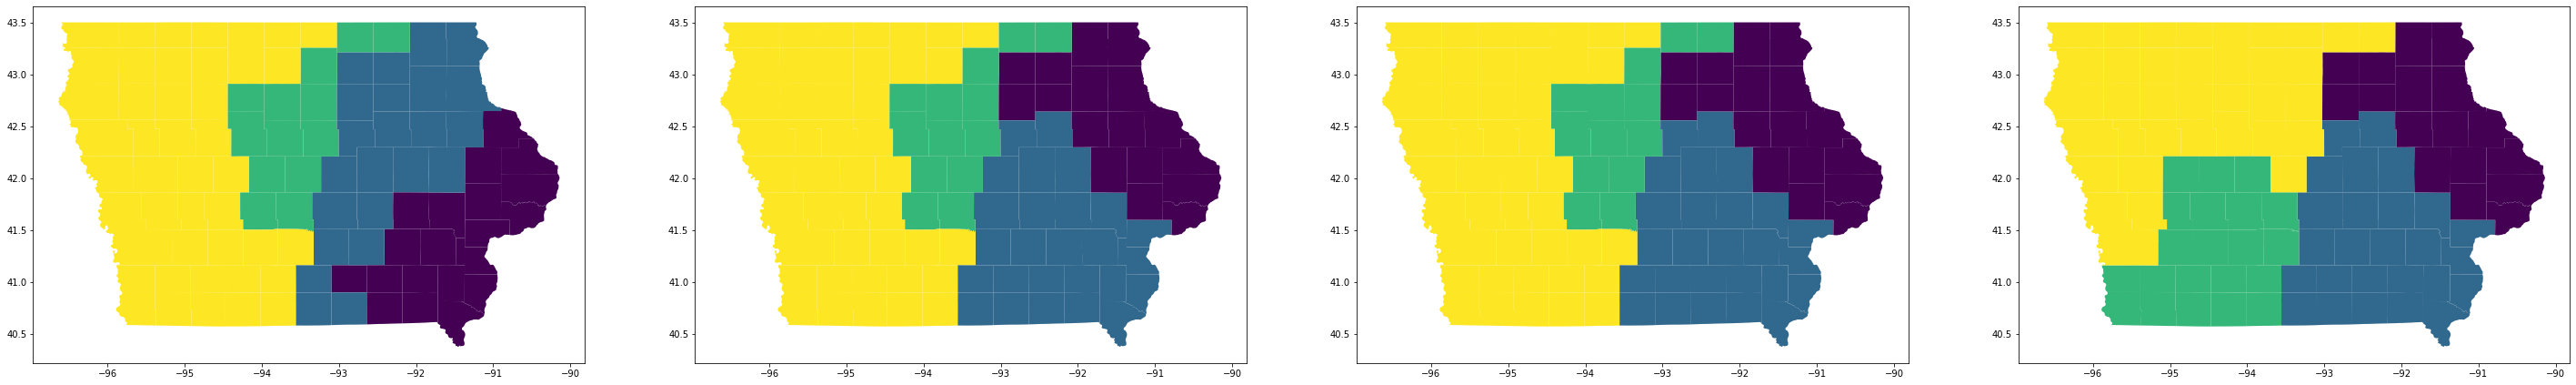

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(50,100))
gdf.plot(column="recomstep{}".format(9),ax=axes[0])
gdf.plot(column="recomstep{}".format(10),ax=axes[1])
gdf.plot(column="recomstep{}".format(11),ax=axes[2])
gdf.plot(column="recomstep{}".format(12),ax=axes[3])

<Axes: >

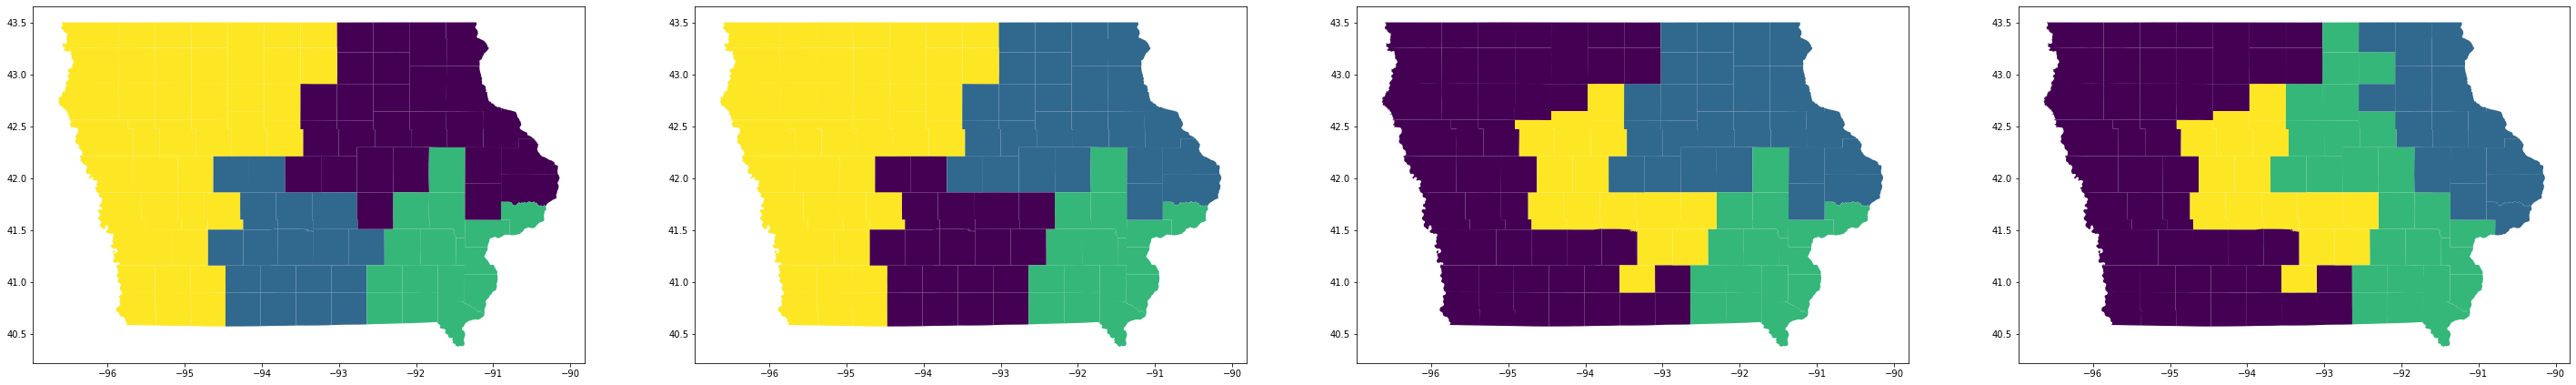

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(50,100))
gdf.plot(column="recomstep{}".format(109),ax=axes[0])
gdf.plot(column="recomstep{}".format(110),ax=axes[1])
gdf.plot(column="recomstep{}".format(111),ax=axes[2])
gdf.plot(column="recomstep{}".format(112),ax=axes[3])

<Axes: >

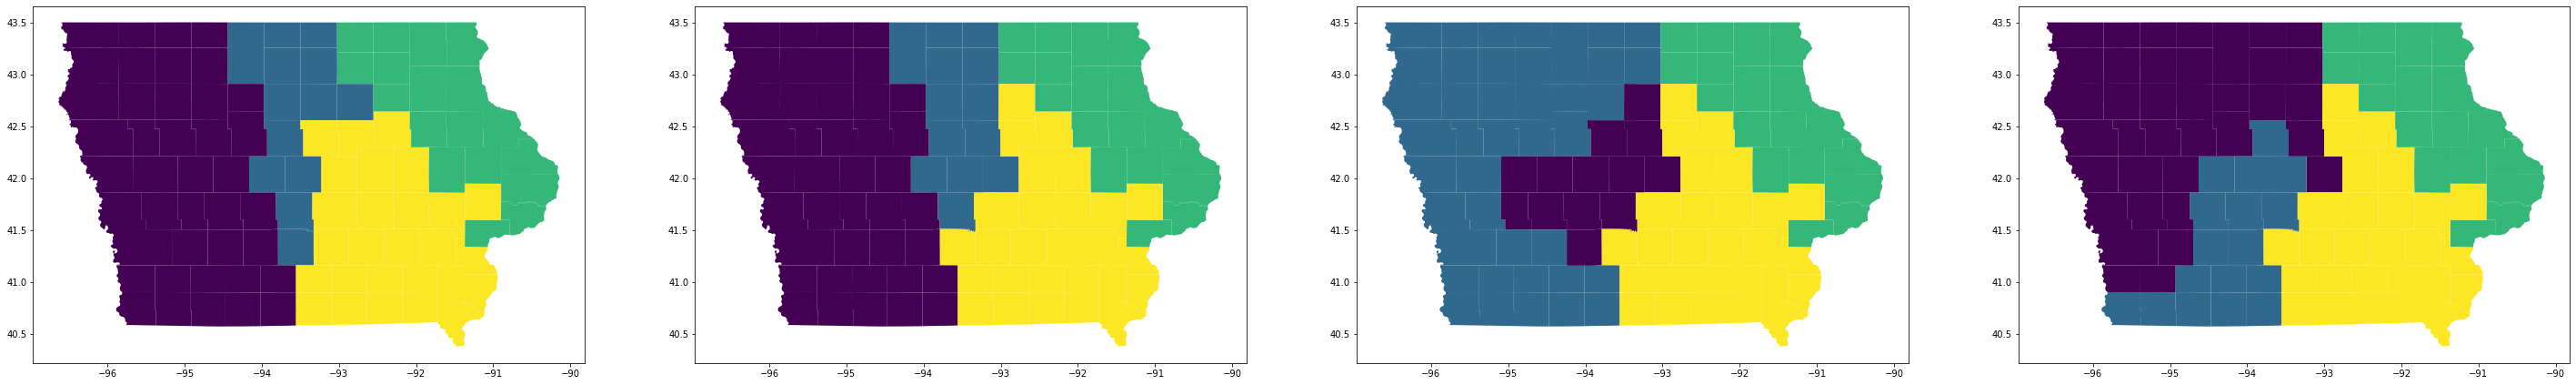

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(50,100))
gdf.plot(column="recomstep{}".format(809),ax=axes[0])
gdf.plot(column="recomstep{}".format(810),ax=axes[1])
gdf.plot(column="recomstep{}".format(811),ax=axes[2])
gdf.plot(column="recomstep{}".format(812),ax=axes[3])

Now we look at a summary statistic again:  let's see the Obama vote share in the four districts across 1000 flip plans or 1000 ReCom plans.  We immediately see that ReCom finds more variety.  One diagnostic of whether you've run your chains long enough to achieve Markov chain convergence would be to make sure your boxplot doesn't change too much if you start in a different place ("multistart heuristic") or lengthen the chains substantially.  But remember there's no guarantee that the Flip and ReCom boxplots would look the same as each other even if you ran each one for an enormously long time; they could simply have different stationary distributions.

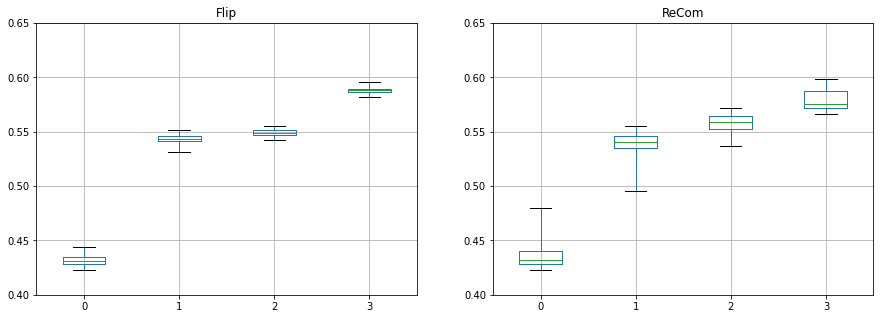

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
recomvoteshares = pd.DataFrame(votesharelists['PRES12'])
recomvoteshares.boxplot(whis=(1,99),showfliers=False,ax=axes[1])
axes[1].set_ylim(.4,.65)
axes[1].set_title('ReCom')
flipvoteshares.boxplot(whis=(1,99),showfliers=False,ax=axes[0])
axes[0].set_ylim(.4,.65)
axes[0].set_title('Flip')
plt.show()


We can easily store our vote share data for later as a csv.

In [ ]:
recomvoteshares.to_csv(
    'PRES12_D_ReCom_shares.csv',
    index_label='step'
)

Let's look at the cut edges histogram from the ReCom run alongside the Flip cut edges distribution from earlier. 

Above the plot, you can see the actual numbers of plans in each bin.

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  2.,  4.,  7.,  9., 15., 26., 22., 30.,
       38., 36., 33., 28., 45., 44., 49., 49., 58., 54., 61., 58., 48.,
       57., 52., 42., 27., 28., 27., 15., 16., 10.,  3.,  2.,  4.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]), array([20., 21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.,
       33., 34., 35., 36., 37., 38., 39., 40., 41., 42., 43., 44., 45.,
       46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56., 57., 58.,
       59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70., 71.,
       72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83.]), <BarContainer object of 63 artists>)


(array([  0.,   0.,   2.,   4.,  16.,  24.,  48.,  73.,  81., 111., 103.,
         96.,  81.,  73.,  71.,  45.,  41.,  29.,  21.,  25.,  17.,  16.,
          8.,   8.,   2.,   2.,   0.,   3.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]),
 array([30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
        43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68.,
        69., 70., 71., 72., 73., 74.]),
 <BarContainer object of 44 artists>)

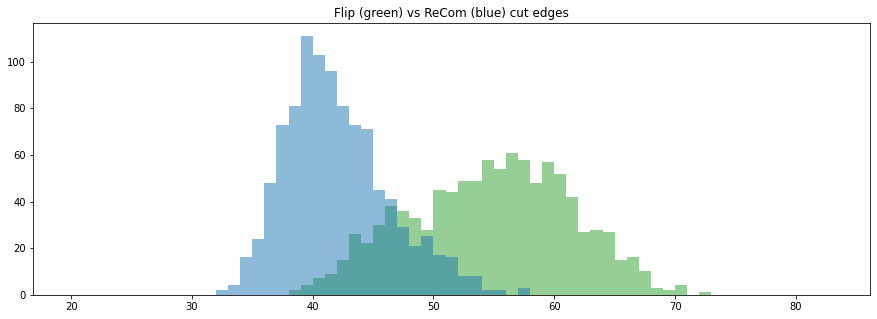

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
print(ax.hist(cutedges,bins=range(20,84),alpha=.5,color='tab:green'))
ax.set_title("Flip (green) vs ReCom (blue) cut edges")
ax.hist(recomcutedges,bins=range(30,75),alpha=.5,color='tab:blue')

And that's it! Feel free to go ahead and play with the parameters above, store different kinds of data for the runs, or even try a whole new state from mggg-states.

## Some bonus challenges

### In QGIS
You can store a special plan to look at later in QGIS. For example, here we will store the plan which has the most Democratic district in the ensemble. We'll add it as a column called "myplan" and save it to a shapefile.

In [ ]:
plan_with_highest_D = recomvoteshares[3].argmax()
fresh_gdf = gpd.read_file("IA_counties.shp")
fresh_gdf['myplan'] = gdf["recomstep{}".format(plan_with_highest_D)]
fresh_gdf.to_file("IA_highest_D.shp")

We can now download our file and open it up QGIS for further analysis and visualization. For example, we can plot the boundaries of myplan over the election data from PRES12. 

### In GerryChain

We can replace always_accept with an acceptance function that preferentially accepts compact plans. E.g.:

In [ ]:
def myaccept(step):
  beta = 1
  proposedce = len(step['cut_edges'])
  parentce = len(step.parent['cut_edges'])
  probability_of_accept = np.exp(beta*(parentce-proposedce))
  return random.random() < probability_of_accept

Try running the chain with the myaccept function instead of always_accept. Check the histogram to make sure it's working. Play with different values of beta.

### In scipy

_Auto-correlation_ refers to the amount of dependence between each step and the next in a chain. Or possibly between each step and the step some time later. It is a measure of how well your chain is exploring the space.

We can use scipy.stats.pearsonr to calculate the autocorrelation in the highest Democratic district vote share in a chain. Here it is for recom (it's the first number, the second number is a p-value, which we can ignore for now).

In [ ]:
import scipy.stats

In [ ]:
#the correlation between recomvoteshares[3] and recomvoteshares[3] shifted by one.
lag = 1
scipy.stats.pearsonr(recomvoteshares[3][:-lag], recomvoteshares[3][lag:])

PearsonRResult(statistic=0.7541844332608851, pvalue=2.599964733801343e-184)

Try different values instead of 1. Does the autocorrelation increase or decrease? Try it for the flip chain. Do you notice any differences between the chains?